In [224]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt  

In [225]:
env=gym.make("FrozenLake-v1", desc=None, map_name="4x4",is_slippery=False)

In [226]:
class Policy:
    def __init__(self,initial_policy=None,gamma=0.9):
        self.gamma=gamma
        if initial_policy ==None:
           self.policy=np.full((16,4),0.25)
     
        else:
            self.policy=initial_policy
       
        self.N=np.zeros((16,4,16))
        self.Q=np.zeros((16,4))
        self.v=np.zeros((16))
        self.Returns=[[[] for j in range(4)] for i in range(16)]
        self.pos_dict={i*4+j: [i,j] for i in range(4) for j in range(4)}

    def act(self, state):
        return np.random.choice(4, p=self.policy[state])
    
    def eval_episode(self,episode):
        states, actions, rewards= episode 
        next_state=None
        G=0
        for i, state in reversed(list(enumerate(states))):
            action=actions[i]
            reward=rewards[i]
            G=self.gamma*G + reward
            if i!=0:
                self.N[state][action][next_state]+=1
            if state not in states[:i]:
                self.Returns[state][action].append(G)
                return_numerator=0
                return_denominator=0
                for action_returns in self.Returns[state]:
                    return_numerator+=sum(action_returns)
                    return_denominator+=len(action_returns)
                self.v[state]=return_numerator/return_denominator
            next_state=state
    
    def compute_q(self):
        for state in range(self.Q.shape[0]):
            for action in range(self.Q.shape[1]):

                s_a_visits=np.sum(self.N[state,action])
                if s_a_visits==0:
                    s_a_visits=1 # dirty solution to avoiding nan values
                probs_s_a=self.N[state,action]/s_a_visits
                s_a_rewards=sum(self.Returns[state][action])/s_a_visits
                self.Q[state,action]=np.dot(probs_s_a,self.v)+s_a_rewards

    def improve_policy(self):
        self.compute_q()
        for state in range(self.Q.shape[0]):
            best_action_ind=np.argmax(self.Q[state])
            new_action_distrib=np.zeros(4)
            new_action_distrib[best_action_ind]=1
            self.policy[state] = new_action_distrib

    def v_mat(self):
        V_mat=np.zeros((4,4))
        for i, val in enumerate(self.v):
            in_1, in_2=self.pos_dict[i]
            V_mat[in_1,in_2]=val
        return V_mat
    
    def policy_mat(self):
        pi_mat=np.zeros((4,4,4))
        for i  in range(self.policy.shape[0]):
            in_1, in_2=self.pos_dict[i]
            pi_mat[in_1,in_2]=self.policy[i]
        return pi_mat
       
    def show_heatmap(self):
        fig, ax = plt.subplots()
        V_mat=self.v_mat()
        im = ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(4))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, round(V_mat[i, j], 2),
                            ha="center", va="center", color="w")

        ax.set_title("State value function heatmap")
        fig.tight_layout()
        plt.show()
    
    def show_policy(self):
        Pi_mat=self.policy_mat()
        V_mat=self.v_mat()
        policy_arrows = {0: '←', 1: '↓', 2:'→' , 3:'↑' }

        fig, ax = plt.subplots()
        ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(4))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(4):
            for j in range(4):
                best_action = np.argmax(Pi_mat[i, j])
                text = ax.text(j, i, policy_arrows[best_action],
                            ha="center", va="center", color="w")

        ax.set_title("Frozen World Optimal Policy")
        fig.tight_layout()
        plt.show()
            

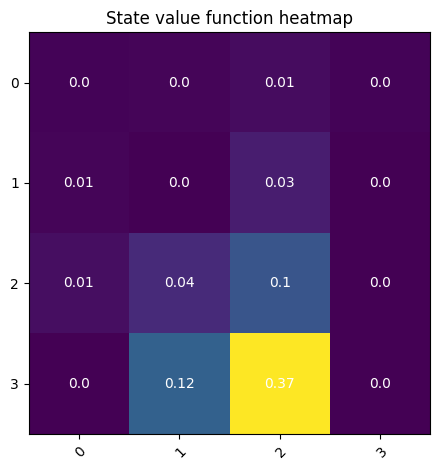

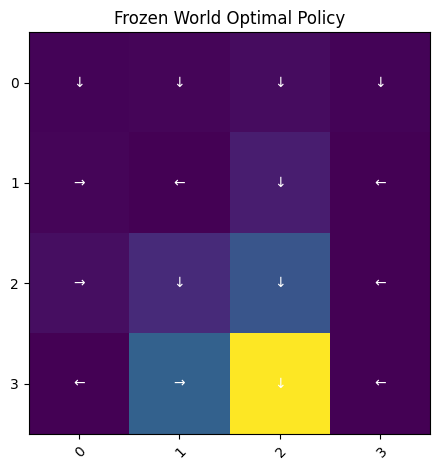

In [229]:
my_policy=Policy()
max_eps_length=100
how_many_eps=10000


for eps_nr in range(how_many_eps):
    env.reset()
    episode=[[],[],[]]
    state, _ =env.reset()
    for i in range(max_eps_length):
        episode[0].append(state)
        action = my_policy.act(state)
        state, reward, terminated, truncated, _ = env.step(action) 
        episode[1].append(action)
        episode[2].append(reward)
        
        if terminated or truncated:
            break
    my_policy.eval_episode(episode)
my_policy.show_heatmap()
my_policy.improve_policy()
my_policy.show_policy()




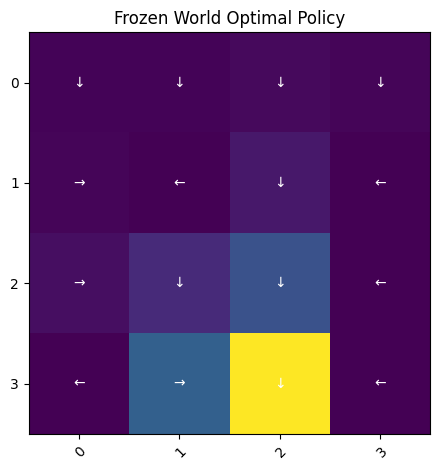

In [228]:
my_policy.show_policy()